In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [80]:
from fbprophet import Prophet

In [81]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORT SALE INFORMATION DATA

In [82]:
# there are 2 types of dataset that we have
# sales_train_df ---> Transactiona made
# ds2 ---> store data.
sales_train_df= pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [83]:
### almost a million observation 
#### 1115 unique stores 
#### Note that sales is the target variable (that's what we are trying predict) 
#### Id: transaction ID (combination of Store and date) 
##### Store: unique store Id
##### Sales: sales/day, this is the target variable 
##### Customers: number of customers on a given day
##### Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
##### Promo: describes if store is running a promo on that day or not
##### StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
##### SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

#####- Data Source: https://www.kaggle.com/c/rossmann-store-sales/data

In [84]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [85]:
sales_train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [86]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [87]:
# 9 columns in total 
# 8 features, each contains 1017209 data points
# 1 target variable (sales)

In [88]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [89]:
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

# IMPORT STORE INFORMATION DATA

In [90]:
# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store




In [91]:
store_train_df = pd.read_csv('/content/drive/MyDrive/Dataset/store.csv')

In [92]:
store_train_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [93]:
# Let's do the same for the store_info_df data
# Note that the previous dataframe includes the transactions recorded per day (in millions)
# This dataframe only includes information about the unique 1115 stores that are part of this study 


In [94]:
store_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [95]:
store_train_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## **EDA----> TRANSACTION INFORMATION DATA**

In [96]:
sales_train_df.isnull().sum() # Transaction dataset

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74cb869910>,
      dtype=object)

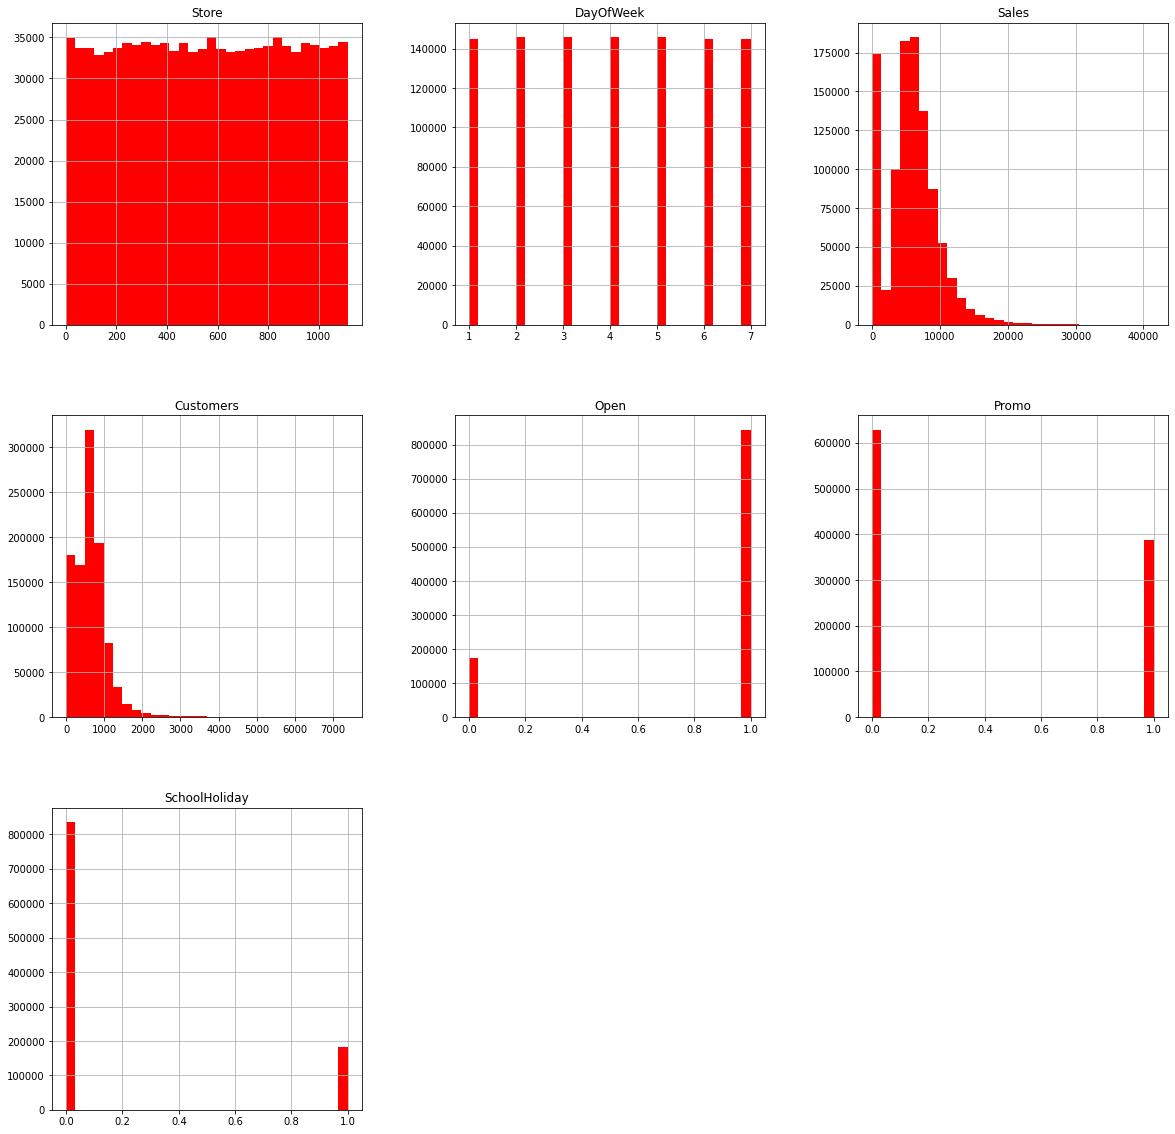

In [97]:
sales_train_df.hist(bins=30, figsize=(20,20), color='r')

In [98]:
# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time 
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time

In [99]:
# Maximum number of customer
sales_train_df['Customers'].max()

7388

In [100]:
# See how many stores are open/closed
closed_train_df = sales_train_df[sales_train_df['Open']==0]
open_train_df = sales_train_df[sales_train_df['Open']==1]

In [101]:
print('Total Closed Stores =', len(closed_train_df))
print('*****************************************')
print('Total Open Stores =', len(open_train_df))

Total Closed Stores = 172817
*****************************************
Total Open Stores = 844392


In [102]:
# See how many stores are open/closed
sales_train_df['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [103]:
# Removing the data for the closed stores
sales_train_df = sales_train_df[sales_train_df['Open']==1]

In [104]:
sales_train_df.shape

# When both the open and closed stores were included then len of dataset= 1017209
# When only open stores were included then len of dataset=  844392

(844392, 9)

In [105]:
# Droping the open column as no more required as all stores are now only for open category
sales_train_df = sales_train_df.drop(columns=['Open'],axis=1)

In [106]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [107]:
# after droping the closed store values the statistics have changed
# check for the new statistics of dataset.
# Average sales = 6955 Euros,	average number of customers = 762	(went up)
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


## EDA ON STORE INFORMATION ***DATA*** 

In [108]:
# checking for missing data in both the daatsets

store_train_df.isnull().sum() # Store dataset

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [109]:
store_train_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [110]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing
# Let's set these values to zeros 

df_no_Promo2= store_train_df[store_train_df['Promo2']==0]


In [111]:
df_no_Promo2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN


In [112]:
# Setting these columns to 0--> ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing so we set that to 0 too
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in str_cols:
    store_train_df[str].fillna(0, inplace = True)

In [113]:
 store_train_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [114]:
# placing the CompetitionDistance missing value  with average value.
store_train_df['CompetitionDistance'].fillna(store_train_df['CompetitionDistance'].mean(), inplace = True)

In [115]:
 store_train_df.isnull().sum() # ALL NULL VALUES GONE,

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74c58f1350>,
      dtype=object)

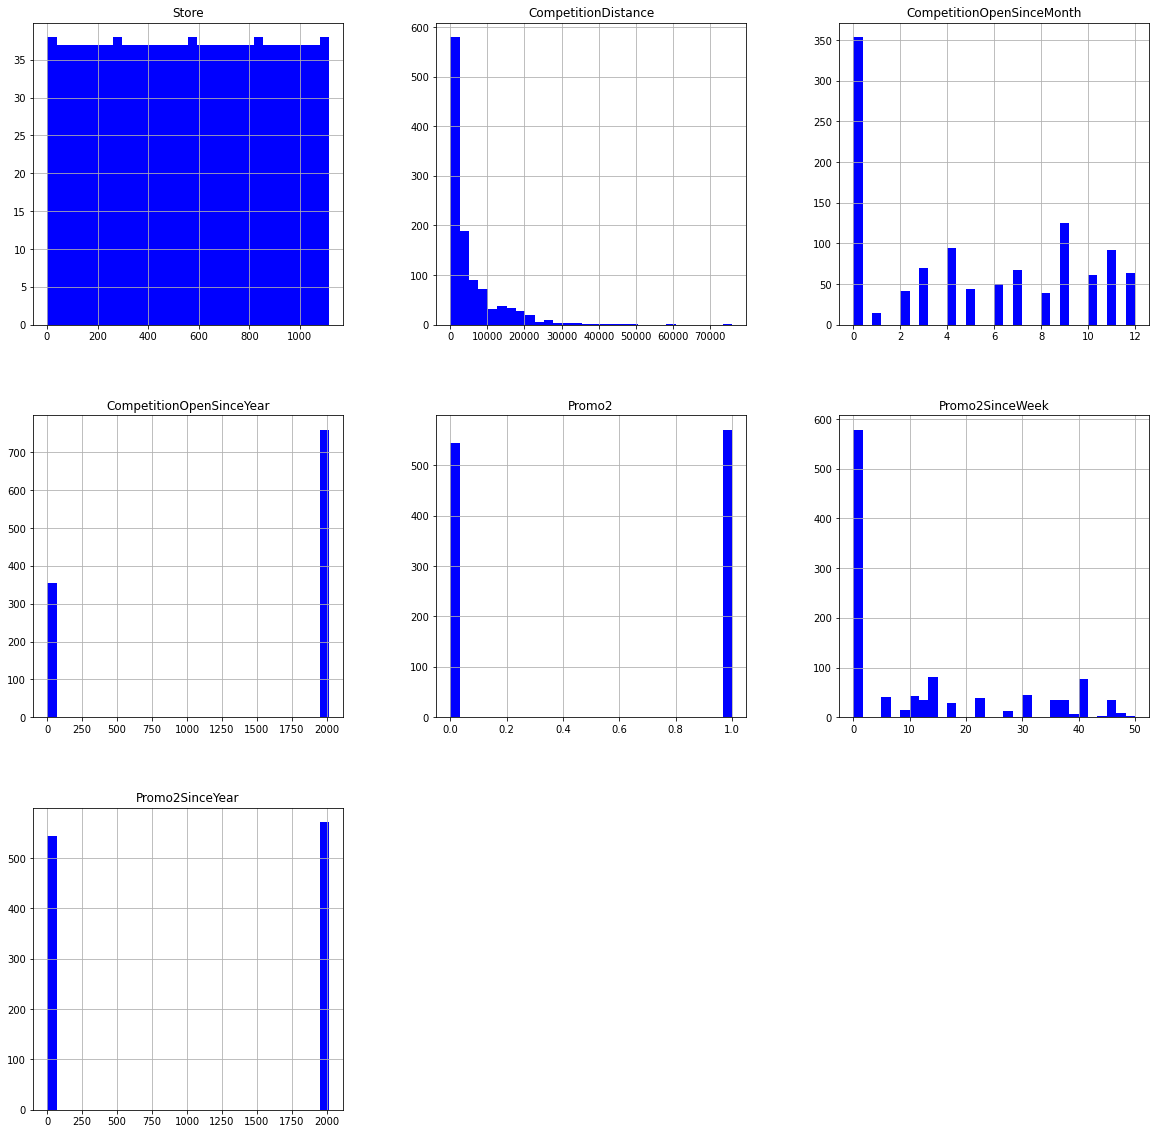

In [116]:
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)
# Plotting the histogram
store_train_df.hist(bins=30, figsize=(20,20), color='b')

## ***Explore Merged Dataset***

In [117]:
# Let's merge both data frames together based on 'store'
# merging based on store column
df_all= pd.merge(sales_train_df,store_train_df, how='inner', on='Store')

In [118]:
df_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [119]:
# checking for correlation
corr = df_all.corrwith(df_all.Sales)

In [120]:
corr

Store                        0.007710
DayOfWeek                   -0.178736
Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
SchoolHoliday                0.038617
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
Promo2SinceYear             -0.127621
dtype: float64

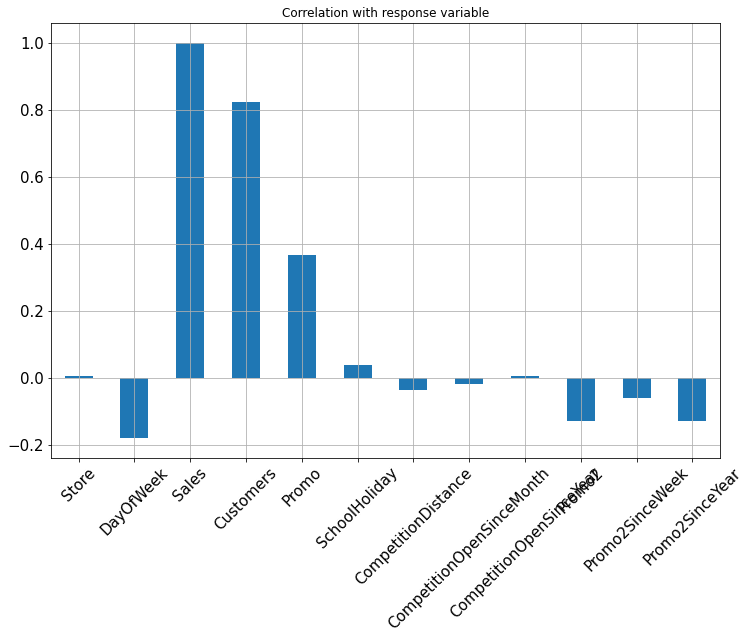

In [121]:
corr.plot.bar(figsize=(12,8), title='Correlation with response variable', fontsize=15, rot=45, grid=True)

In [122]:
corr2 =  df_all.corr()

In [123]:
import seaborn as sns

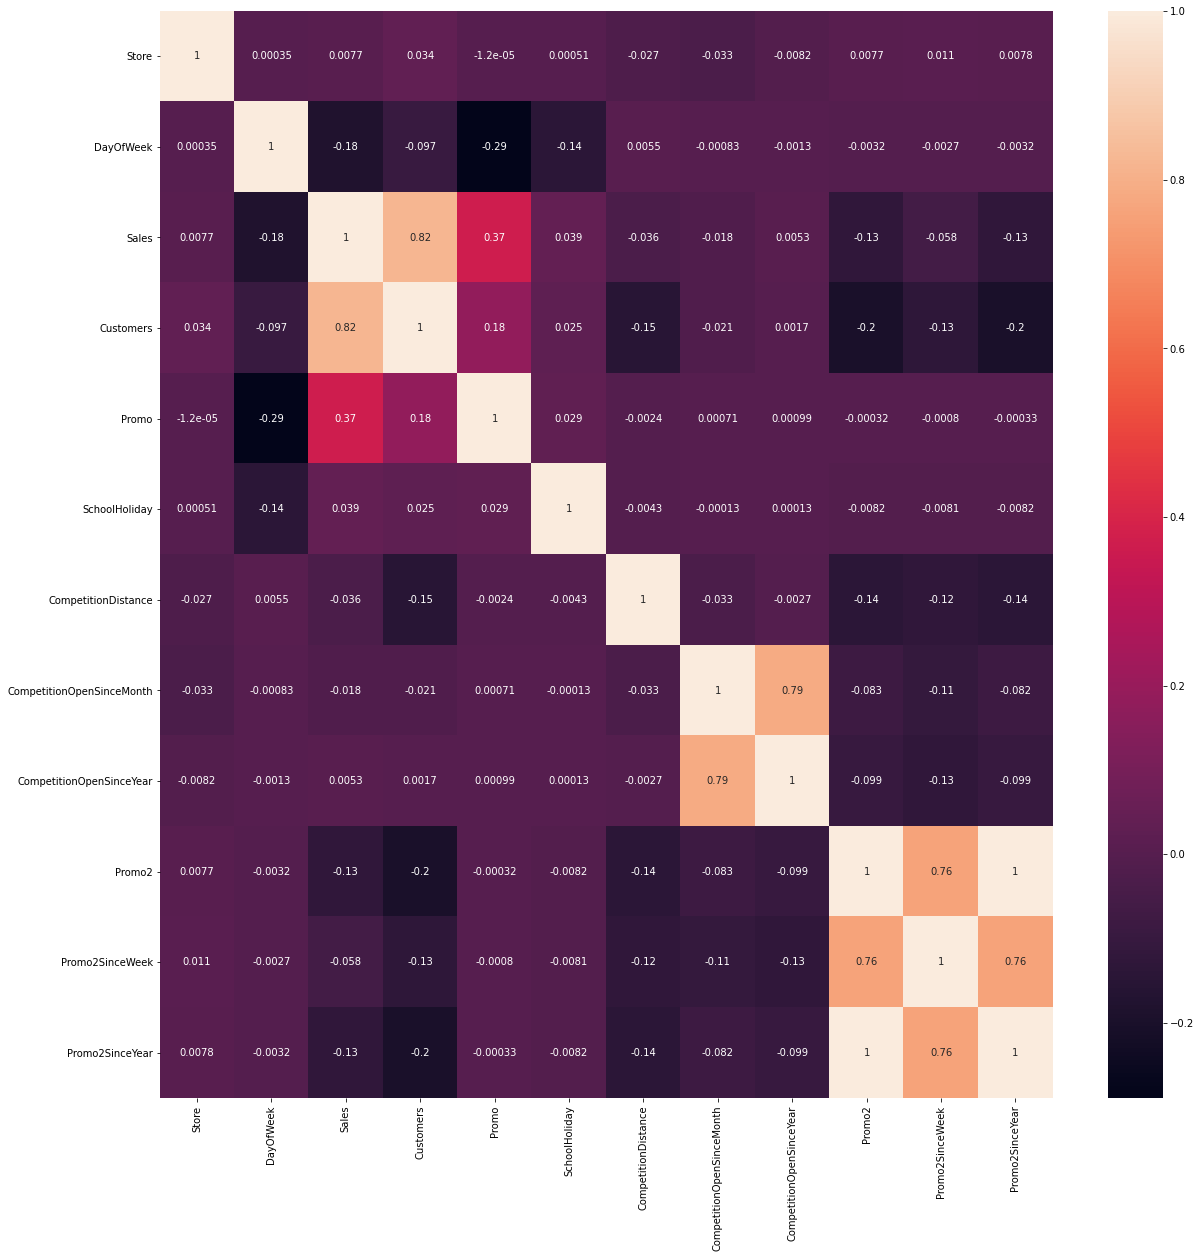

In [124]:
# Plotting heat map
plt.figure(figsize=(20,20))
sns.heatmap(corr2,annot=True)

In [125]:
# Seperate the Year Month and Date from Date column
df_all['Year']= pd.DatetimeIndex(df_all['Date']).year

In [126]:
# made a new column at the end called year.
df_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015


In [127]:
# made 2 new columns at the end called month and day.
df_all["Months"]= pd.DatetimeIndex(df_all['Date']).month
df_all['Day']= pd.DatetimeIndex(df_all['Date']).day

In [128]:
df_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Months,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [129]:
#df_all = df_all.drop(columns=['Date'],axis=1)

In [130]:
df_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Months,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


<Figure size 432x288 with 0 Axes>

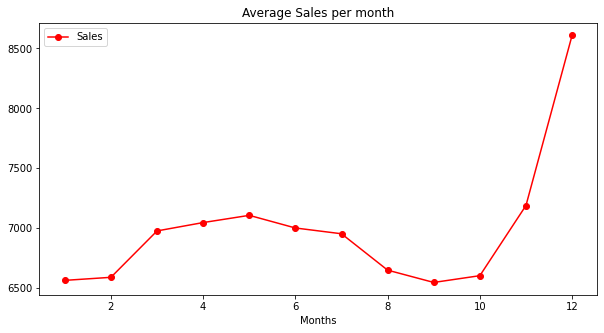

<Figure size 432x288 with 0 Axes>

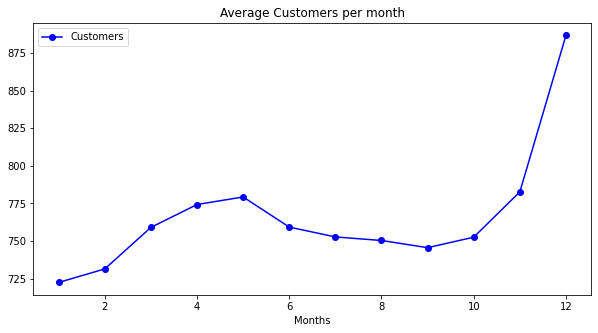

<Figure size 432x288 with 0 Axes>

In [131]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column  
# It looks like sales and number of customers peak around christmas timeframe
# x axis--> months
# y axis--> avg sales/customers per month.

axis= df_all.groupby('Months')[['Sales']].mean().plot(figsize=(10,5), marker='o', color='r')
axis.set_title('Average Sales per month')
plt.figure()

# average customers per month

axis= df_all.groupby('Months')[['Customers']].mean().plot(figsize=(10,5), marker='o', color='b')
axis.set_title('Average Customers per month')
plt.figure()


<Figure size 432x288 with 0 Axes>

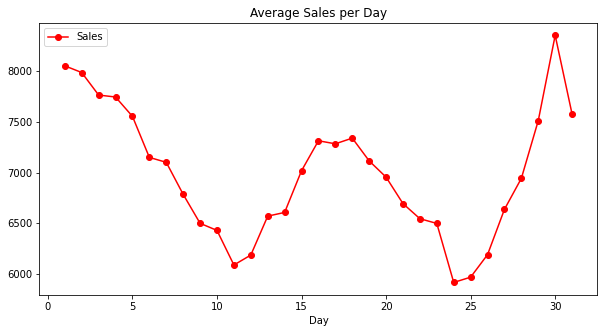

<Figure size 432x288 with 0 Axes>

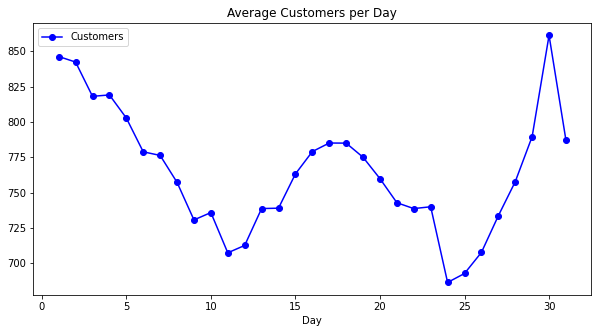

<Figure size 432x288 with 0 Axes>

In [132]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month

axis= df_all.groupby('Day')[['Sales']].mean().plot(figsize=(10,5), marker='o', color='r')
axis.set_title('Average Sales per Day')
plt.figure()

# average customers per day

axis= df_all.groupby('Day')[['Customers']].mean().plot(figsize=(10,5), marker='o', color='b')
axis.set_title('Average Customers per Day')
plt.figure()


<Figure size 432x288 with 0 Axes>

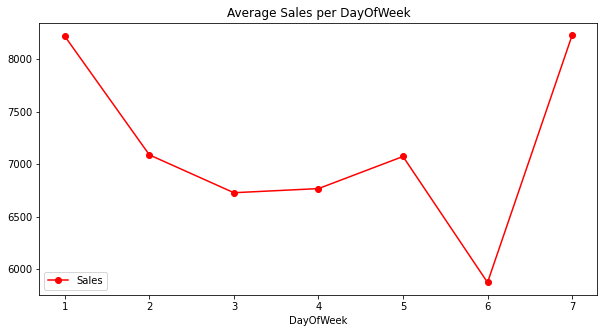

<Figure size 432x288 with 0 Axes>

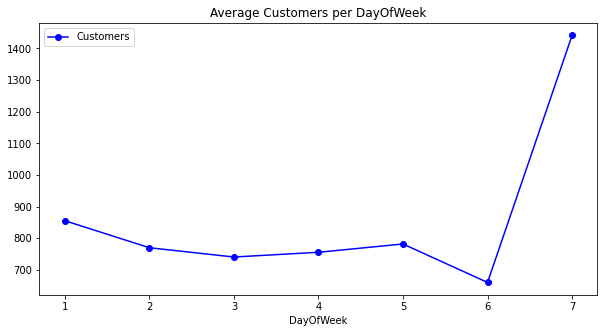

<Figure size 432x288 with 0 Axes>

In [133]:
# Let's do the same for the day of the week  (note that 7 = Sunday)  'DayOfWeek

axis= df_all.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(10,5), marker='o', color='r')
axis.set_title('Average Sales per DayOfWeek')
plt.figure()

# average customers per day

axis= df_all.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(10,5), marker='o', color='b')
axis.set_title('Average Customers per DayOfWeek')
plt.figure()



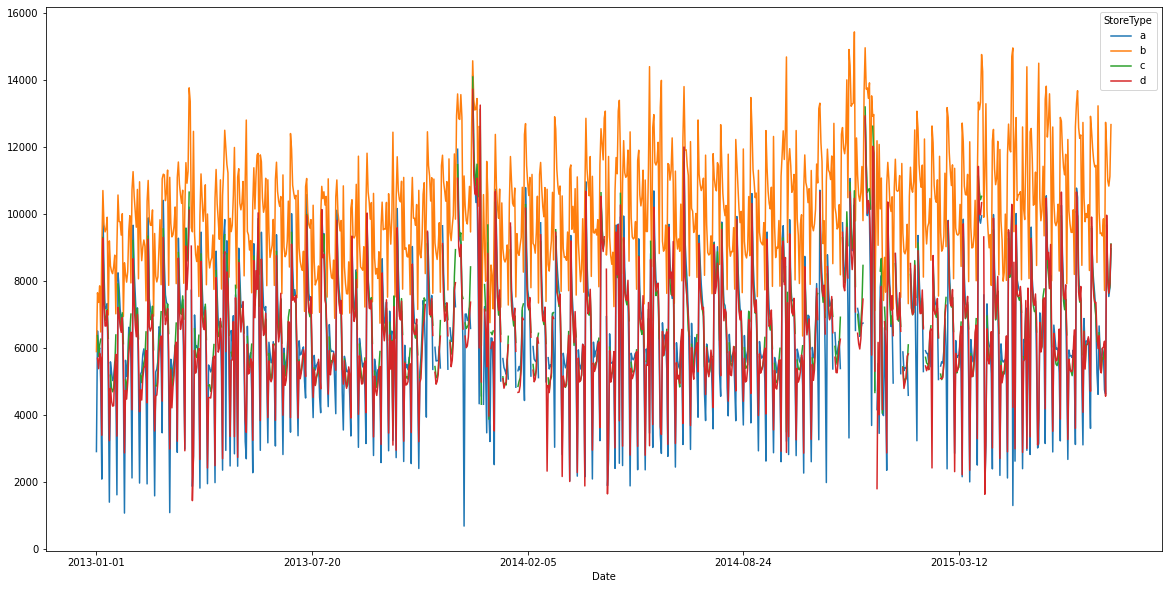

In [134]:
# Plot all the date and store type
# what type of store type is giving what type of data

fig, ax = plt.subplots(figsize=(20,10))
df_all.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax=ax)


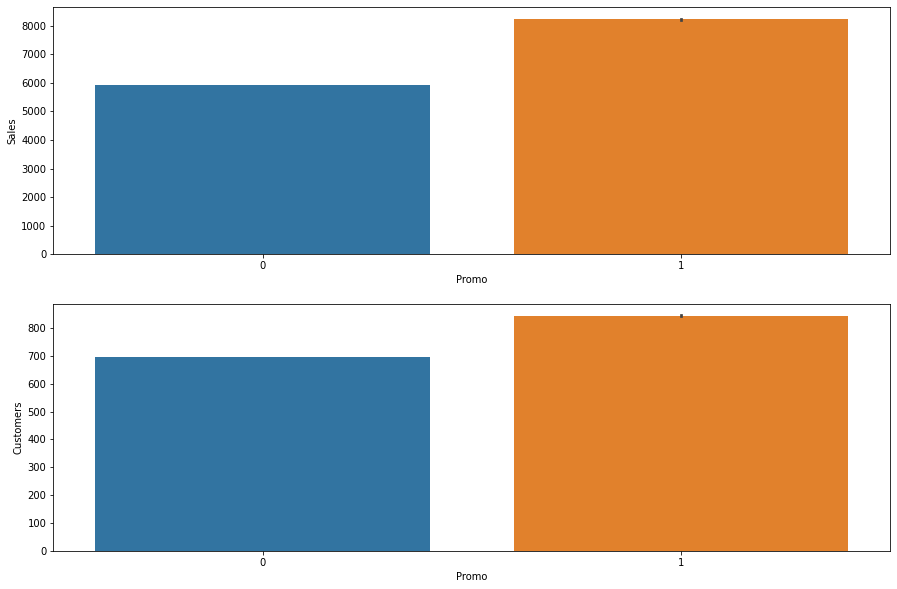

In [135]:
plt.figure(figsize=[15,10])

plt.subplot(211) # 2 rows 1 colum 1st plot
sns.barplot(x = 'Promo', y = 'Sales', data = df_all)

plt.subplot(212) # 2 rows 1 colum 2nd plot
sns.barplot(x = 'Promo', y = 'Customers', data = df_all)

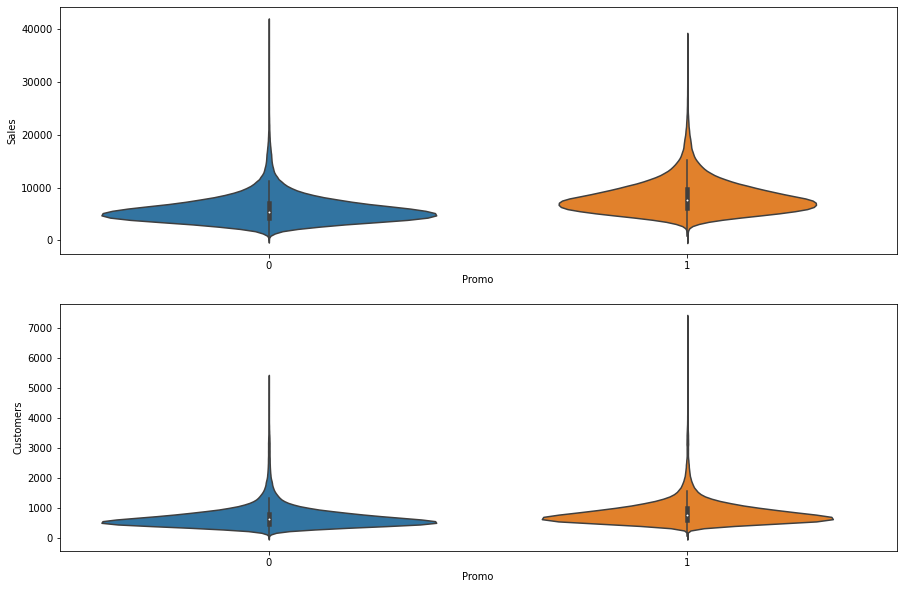

In [136]:
plt.figure(figsize=[15,10])

plt.subplot(211) # 2 rows 1 colum 1st plot
sns.violinplot(x = 'Promo', y = 'Sales', data = df_all)

plt.subplot(212) # 2 rows 1 colum 2nd plot
sns.violinplot(x = 'Promo', y = 'Customers', data = df_all)

# ***FACEBOOK PROPHET***
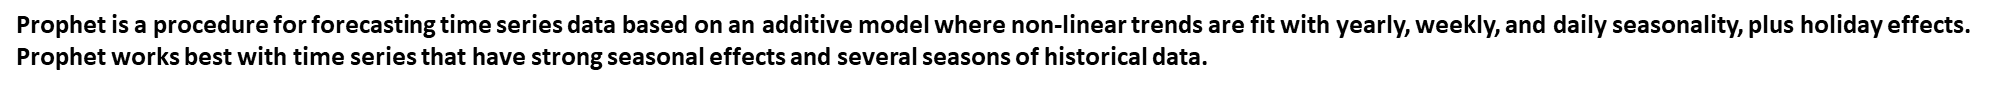


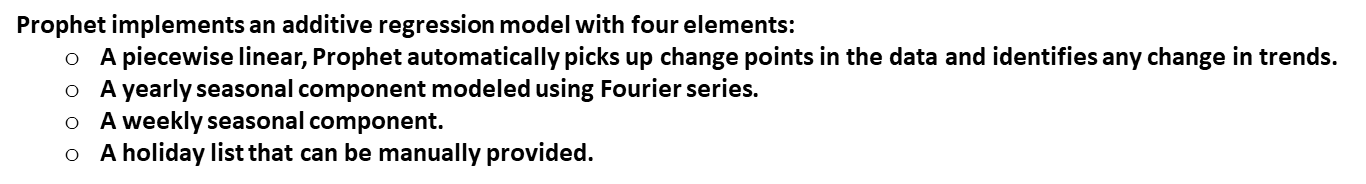

# ***TRAIN THE MODEL***

In [137]:
from fbprophet import Prophet

In [138]:
df_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Months,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [139]:
# ds--> Date
#y --> Sales
  # Function that takes in the data frame, storeID, and number of future period forecast
  # The function then generates date/sales columns in Prophet format
  # The function then makes time series predictions

def sales_prediction(Store_ID, sales_df, periods):
  saled_df= sales_df[sales_df['Store']== Store_ID]
  sales_df = sales_df[['Date','Sales']].rename(columns={'Date':'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')

  model = Prophet()
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure= model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2 = model.plot_components(forecast)
  # return sales_df--> this was for validation purpose only. but not required after model building.
  # After the model building tep we will get the graphical visualisation of figure 1, and figure 2.
   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


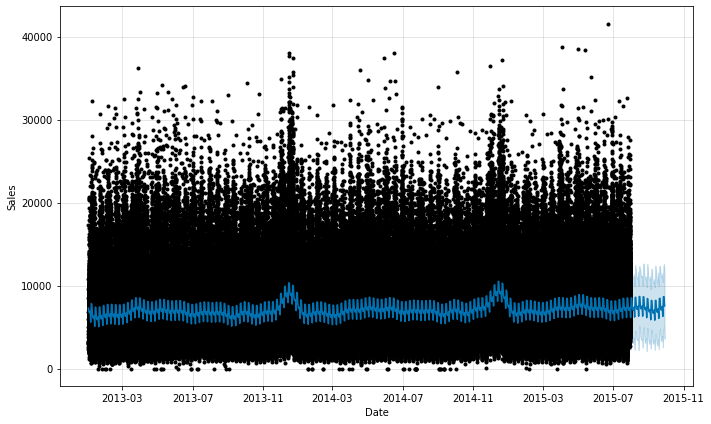

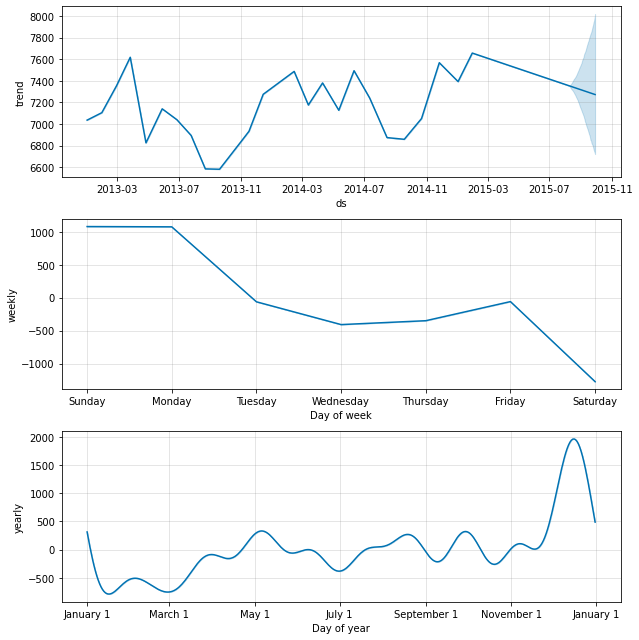

In [140]:
sales_prediction(10, df_all, 60)

### ***TRAIN THE MODEL PART B***

In [141]:
#StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

In [142]:
def sales_prediction(Store_ID, sales_df, holidays, periods):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

In [143]:
# Get all the dates ppertaining to school holidays
school_holidays = df_all[df_all['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [144]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [145]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

In [146]:
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [147]:
# Get all the dates ppertaining to state holidays
state_holidays = df_all[ (df_all['StateHoliday'] == 'a') | (df_all['StateHoliday'] == 'b') | (df_all['StateHoliday'] == 'c')  ].loc[:, 'Date'].values
state_holidays.shape

(910,)

In [148]:
state_holidays= pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

In [149]:
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [150]:
# concatenate both school and state holidays 
school_state_holidays = pd.concat((state_holidays, school_holidays))

In [151]:
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


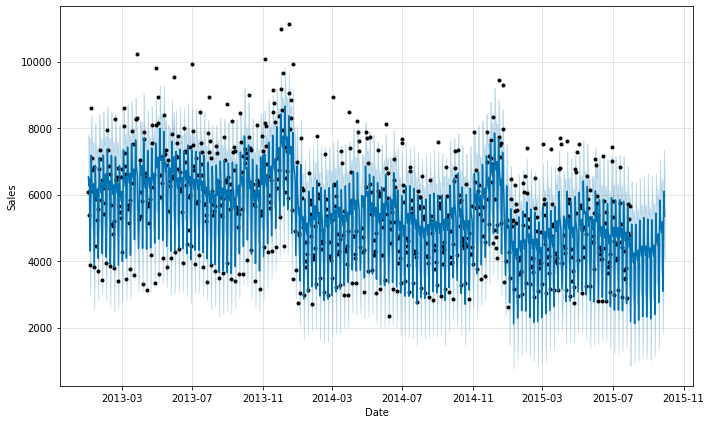

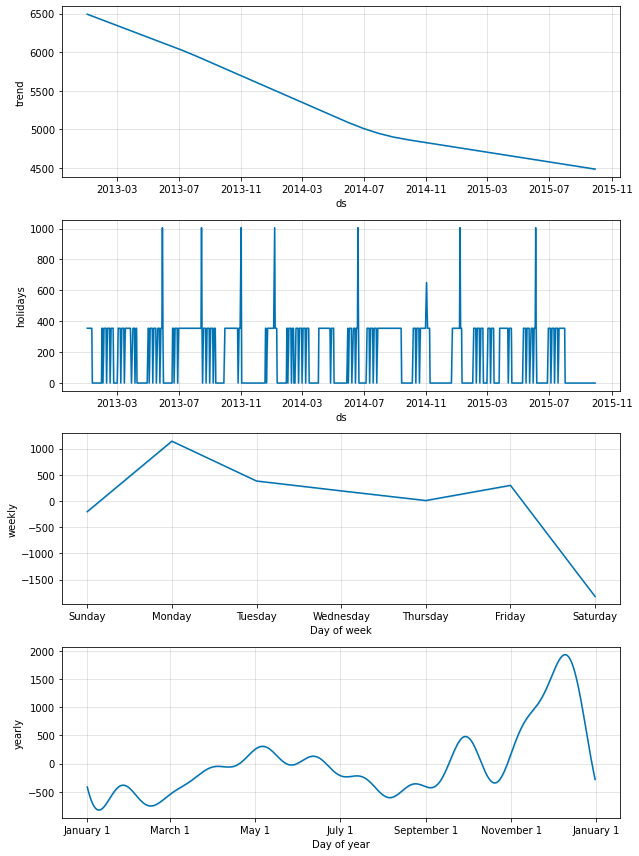

In [152]:
# Let's make predictions using holidays for a specific store
sales_prediction(6, df_all, school_state_holidays, 60)